# Введение

**Основные задачи, решаемые в страховании**
* Классические задачи:
    * тарификация
    * антифрод
    * расчет комиссии посредников
* ML дало развитие задачам:
    * скоринг клиентов
    * оценка риска
    * оценка ущерба (резерва)
    * вероятность пролонгации
    * вероятность покупки опций
    * вероятность кросс-продаж
    * оценка параметров, неизвестных на начальном этапе (например, балл БКИ на предварительном расчете)
    * варианты развития убытка (вероятность отказа в выплате, вероятность суда, мошенничества)
    * распознавание марок-моделей ТС по фото
    * распознавание повреждений ТС по фото

**Риски, оцениваемые в автостраховании**
* Повреждения кузова
  * наш клиент виновен / невиновен
  * крупные / мелкие убытки
* Ущерб здоровью и жизни
* Обязательная гражданская ответственность (ОСАГО)
* Добровольная гражданская ответственность (ДАГО)
* Повреждения в результате действия третьих лиц
* Тоталь
* Угон
* Прочее

**Основная идея метода бустинга**
* Строится модель, прогнозирующая целевую переменную
* Находятся отклонения между прогнозными и фактическими значениями
* Отклонения - новая целевая переменная
* Строится модель, прогнозирующая отклонения
* Находятся новые отклонения после применения двух моделей
* Новые отклонения - снова целевая переменная
* ...

  ![](https://drive.google.com/uc?export=view&id=1S6rBG3Jn0nTww-X_Fs3h00F9OvkXHgUA)

**Особенности бустинга "деревянных" моделей**
* Бόльшая склонность к переобучению, чем у линейных моделей
* Требовательность к подбору гиперпараметров
* Сложность с трактовкой значимости параметров

**Схема решающего дерева для задачи классификации**

  ![](https://drive.google.com/uc?export=view&id=1WlLe4akj2-8LsEeWoS8lCDzATkMKzcO1)



Основная мера неоднородности при построении деревьев - энтропия Шеннона
  ![](https://drive.google.com/uc?export=view&id=16FWKv29X4qFkvi8W0MMN9rkOm4TFByq8) ,
где p - вероятность состояния, i - состояние системы. Чем выше энтропия, тем больше хаоса.

  ![](https://drive.google.com/uc?export=view&id=1Dl9u-uwnpBn6a4ORFBXrXMFMDrbBjLtH)

  ![](https://drive.google.com/uc?export=view&id=1f77y84obWiPmX2W57N5cdm4RlVQCz3wf)

  ![](https://drive.google.com/uc?export=view&id=1amL7hYh0D3LEJQt0Ntr1JdqClEgNDODV)

 Прирост информации (изменение энтропии)
  ![](https://drive.google.com/uc?export=view&id=1LPgPB2aSvvhVYa2qD3Kgy-XTD-2oVx5G)

**Алгоритм построения решающих деревьев**
* Вычисляем энтропию исходного множества
* Если энтропия равна 0, значит все объекты принадлежат к одному классу
* Разбиваем исходное множество на два подмножества, вычисляем изменение энтропии
* Среди всех возможных разбиений выбираем то, у которого изменение энтропии наибольшее
* Повторяем процесс: разбиваем каждое из полученных подмножеств

  ![](https://drive.google.com/uc?export=view&id=1Q-qEQLZ-sjPQrei-EBxpmBS9yfZTKU2o)

**Для задачи регрессии**
* Мера неоднородности - это ошибка на выборке

**Градиентный спуск**
* Поиск минимума ошибки за счет движения в сторону антиградиента

**Что работает лучше, деревья решений или линейные модели?**
* Ответ зависит от ситуации с данными
* В страховых задачах оценки риска преимущество "деревянных" моделей неочевидно

# Решение задачи оценки ожидаемых выплат по полису КАСКО методом градиентного бустинга

# Предобработка данных

In [1]:
# Подключение к Google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# warnings.filterwarnings = 'ignore'

## Специфические преобразования

In [4]:
# PATH = '/content/drive/MyDrive/мои временные ряды/'
PATH = ''

In [5]:
# Загрузим набор данных

df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [6]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [7]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [8]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [9]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea'],
      dtype='object')

In [10]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [11]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


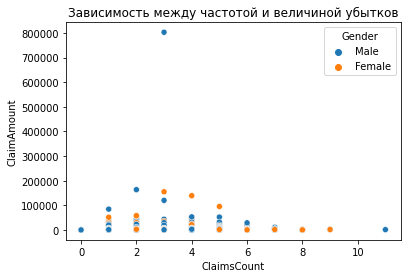

In [12]:
sns.scatterplot( x = df['ClaimsCount'],y = df['ClaimAmount'], hue = df.Gender)
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [13]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [14]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [15]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [16]:
data = InsDataFrame_Fr()

In [17]:
data.load_pd(df)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [19]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [20]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [21]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

In [22]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [24]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [25]:
col_features1 = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
    
]

In [26]:
col_features=col_features1

In [27]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [28]:
df_freq = data.get_pd(col_features+col_target)

In [29]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# import sklearn

In [32]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [33]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

# Градиентный бустинг

Градиентный бустинг - ансамблевый метод машинного обучения, использующийся для задач классификации, регрессии и ранжирования. Ансамбль представляет собой композицию простых базовых алгоритмов, в качестве которых обычно используются деревья решений. 

Классический алгоритм GBM был предложен [Джеромом Фридманом в
1999 году](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). Популярность методов GBM пришла в 2015-2016 гг. благодаря большому
успеху библиотеки XGBoost в соревнованиях Kaggle.

Популярные библиотеки для GBM:
* XGBoost (eXtreme Gradient Boosting)
    * скорость, масштабируемость, поддержка распределенных вычислений
    * добавление компоненты регуляризации, отсутствовавшей в классическом алгоритме GBM
* LightGBM
    * использование алгоритмов, основанных на гистограммах, которые позволяют сократить время исполнения и потребление памяти в процессе обучения моделей. 
* CatBoost (Categorical Boosting)
    * предназначается для эффективной работы с категориальными признаками

Все перечисленные библиотеки зачастую имеют сравнимый результат.

### Теория (XGBoost)

**Модель**

Пусть $y_i$ – значение переменной, которое необходимо предсказать, $x_i$ – входные данные.

Модель имеет вид
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i),\hspace{10pt} f_k \in \mathcal{F},$$
где $K$ – количество деревьев, $f$ – функция на пространстве $\mathcal{F}$, которое содержит все возможные деревья решений.

**Целевая функция**
$$\text{Obj}(\theta) = L(\theta) + \Omega(\theta),$$
где 
* $\theta$ – параметры модели;
* $L$ – величина потерь на обучающей выборке  (насколько хорошо модель описывает данные?);
* $\Omega$ – компонента, отвечающая за регуляризацию (насколько модель сложная?).

Тогда для представленной модели $\theta = \{f_1,f_2,\cdots,f_K\}$,

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K\Omega(f_k),$$
где $l(y_i, \hat{y}_i)$ – функция потерь.

**Обучение**

Необходимо обучить функции $f_i$, каждая из которых включает структуру дерева и значения листьев.

Обозначим $\hat{y}_i^{(t)}$ предсказанное значение на шаге $t$. Тогда целевая функция имеет вид:
$$\text{Obj} = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i).$$

Обучение деревьев происходит поочередно, начиная с постоянного предсказания:
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

На каждом шаге выбирается дерево, которое оптимизирует целевую функцию.
$$\begin{split}\text{Obj}^{(t)} & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{constant}\end{split}$$


Для упрощения задачи оптимизации для заданной функции потерь используется разложение Тейлора:
$$F(x+\Delta x) \simeq F(x) + F'(x)\Delta x + \frac{1}{2} F''(x)\Delta x^2 + \dots$$

Тогда обозначив градиент и гессиан функции потерь соответственно
$$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)}),\hspace{10pt}h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)}),$$
целевая функция будет иметь вид
$$\text{Obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}.$$

Убирая константы на шаге $t$, целевая функция упрощается в виде:
$$\text{Obj}^{(t)} = \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t).$$

Таким образом, величина потерь $L$ зависит только от $g_i$ и $h_i$.

Благодаря этому, XGBoost поддерживает пользовательские целевые функции, для которых достаточно задать градиент и гессиан функции потерь.

**Регуляризация**

Для начала определим дерево $f_t(x)$:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\},$$
где $w$ – вектор значений на листьях дерева, $T$ – количество листьев, $q$ – функция, которая каждой точке набора данных ставит в соответствие лист дерева.

Тогда сложность модели имеет вид
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2+ \alpha \sum_{j=1}^T |w_j|,$$
где $\gamma$ – штраф на сложность деревьев, $\lambda$ – сила регуляризации $\ell_2$, $\alpha$ – сила регуляризации $\ell_1$.

**Переобучение**
Для контроля переобучения помимо параметров $\gamma$, $\alpha$ и $\lambda$ используются также параметры:
* Контролирующие сложность модели напрямую 
    * максимальная глубина дерева (`max_depth`)
    * минимальный вес в узле, ниже которого прекращается дальнейшее разделение в этом узле (`min_child_weight`)
* Добавляющие случайность, повышая устойчивость к зашумлению
    * $\eta$ – величина шага. $\eta \in (0,1]$.
    Вместо $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ используется 
    $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta\cdot f_t(x_i)$
    * Доля подвыборки наблюдений для построения деревьев (`subsample`)
    * Доля подвыборки признаков для построения деревьев (`colsample_bytree`)

Теория, стоящая за оценкой весов на листьях и нахождением разделений выходит за рамки нашего рассмотрения.

* [Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." ](https://arxiv.org/pdf/1603.02754.pdf)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [А. Дьяконов «Введение в анализ данных и машинное обучение». Градиентный бустинг](https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf)
* [Rokach, Lior. Ensemble Learning: Pattern Classification Using Ensemble Methods (Second Edition)](https://books.google.ru/books/about/Ensemble_Learning_Pattern_Classification.html?id=_AmMDwAAQBAJ&redir_esc=y)

### Выбор гиперпараметров

Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

Для подбора параметров воспользуемся реализацией алгоритма Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Алгоритм использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO). Метод основывается в байесовской оптимизации и гауссовских процессах.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [34]:
!pip install hyperopt --upgrade

Requirement already up-to-date: hyperopt in c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages (0.2.5)


In [35]:
!pip install xgboost

In [36]:
from functools import partial
import xgboost as xgb
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

### Построение модели градиентного бустинга для частоты страховых случаев

In [37]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(x_train_c, y_train_c)
valid_c = xgb.DMatrix(x_valid_c, y_valid_c)
test_c = xgb.DMatrix(x_test_c, y_test_c)

In [38]:

# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [39]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [40]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_poisson,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [41]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective': 'count:poisson',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
           
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [42]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))



  2%|▉                                                | 1/50 [00:04<03:27,  4.24s/trial, best loss: 58096.012499799996]

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))



100%|█████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/trial, best loss: 30622.3187502]


In [43]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.8080602039070635,
 'colsample_bytree': 0.5904241384603448,
 'eta': 0.03518855843104822,
 'lambda': 0.6621496903388506,
 'max_depth': 5,
 'min_child_weight': 20.626240825940904,
 'objective': 'count:poisson',
 'subsample': 0.9171939536042628,
 'tree_method': 'hist'}

In [44]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_poisson,
                'maximize': False,
                'verbose_eval': False}

In [45]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train(params=best_params, dtrain=train_c, early_stopping_rounds=10,
                     evals=[(train_c, "train"), (valid_c, "valid")],
                     evals_result=progress, **train_params)

In [46]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(params=best_params, dtrain=train_c, evals=[(train_c, "train"), (valid_c, "valid"), (test_c, "test")],
                           evals_result=progress_wo_es, **train_params)

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))


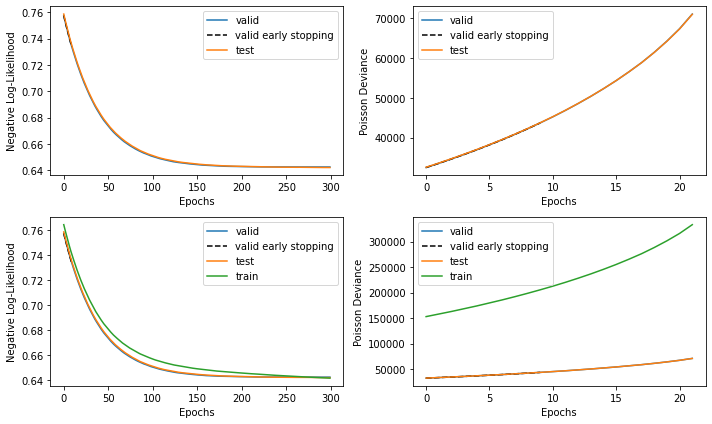

In [47]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.plot(progress_wo_es['train']['poisson-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.plot(progress_wo_es['train']['dev_poisson'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout(); plt.show()

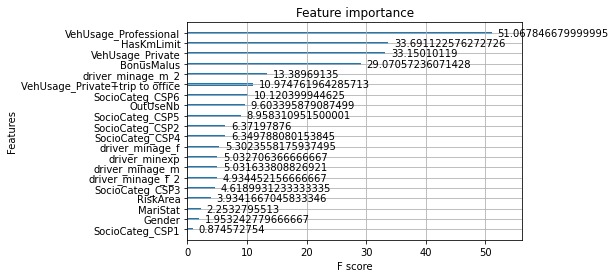

In [48]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[1]); plt.show()

### Построение модели градиентного бустинга для среднего убытка

In [49]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac, y_train_ac)
valid_ac = xgb.DMatrix(x_valid_ac, y_valid_ac)
test_ac = xgb.DMatrix(x_test_ac, y_test_ac)

In [50]:
# Зададим функцию Deviance для гамма-распределения

def xgb_eval_dev_gamma(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [51]:
# Определим границы, в которых будем искать гиперпараметры 

space_avgclm = {'objective': 'reg:gamma',
                'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
                'min_child_weight': hp.uniform('min_child_weight', 0, 50),
                'subsample': hp.uniform('subsample', 0.5, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'alpha': hp.uniform('alpha', 0, 1),
                'lambda': hp.uniform('lambda', 0, 1),
                'eta': hp.uniform('eta', 0.01, 1),
                'tree_method': 'hist'
                }        

In [52]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_gamma,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [53]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_ac),
            space=space_avgclm, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-50-74abb22e96b7>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)



100%|██████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02trial/s, best loss: 480970.30625]


In [54]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_avgclm, best)
best_params

{'alpha': 0.11223320950851906,
 'colsample_bytree': 0.9265437688542401,
 'eta': 0.969675147813349,
 'lambda': 0.580557029774842,
 'max_depth': 5,
 'min_child_weight': 49.095513380799154,
 'objective': 'reg:gamma',
 'subsample': 0.9527793043218815,
 'tree_method': 'hist'}

In [55]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_gamma,
                'maximize': False,
                'verbose_eval': False}

In [56]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_avgclaim = xgb.train(params=best_params, dtrain=train_ac, early_stopping_rounds=10, evals=[(train_ac, "train"), (valid_ac, "valid")],
                         evals_result=progress, **train_params)

In [57]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_avgclaim_wo_es = xgb.train(params=best_params, dtrain=train_ac, evals=[(train_ac, "train"), (valid_ac, "valid"), (test_ac, "test")],
                               evals_result=progress_wo_es, **train_params)

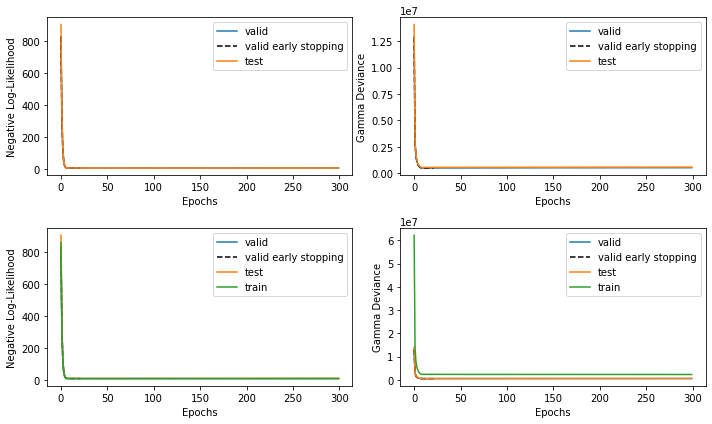

In [58]:
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.plot(progress_wo_es['train']['gamma-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.plot(progress_wo_es['train']['dev_gamma'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout(); plt.show()

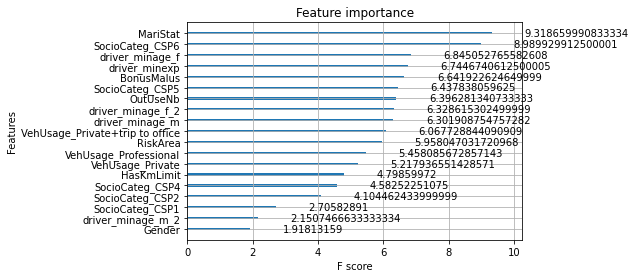

In [59]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_avgclaim, importance_type=importance_type[1]); plt.show()

### Интерпретация моделей градиентного бустинга

* [ELI5 Documentation](https://eli5.readthedocs.io/en/latest/index.html)
* [Константин Лопухин, ELI5: как понять, что выучила ваша ML модель](https://www.youtube.com/watch?v=pqqcUzj3R90)

In [60]:
!pip install eli5

In [61]:
import eli5

c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [62]:
eli5.show_weights( xgb_avgclaim, top = 10)

Weight,Feature
0.0871,MariStat
0.0840,SocioCateg_CSP6
0.0640,driver_minage_f
0.0631,driver_minexp
0.0621,BonusMalus
0.0602,SocioCateg_CSP5
0.0598,OutUseNb
0.0592,driver_minage_f_2
0.0589,driver_minage_m
0.0567,VehUsage_Private+trip to office


In [63]:
eli5.explain_prediction(xgb_avgclaim, x_test_ac.iloc[0,:])

Explanation(estimator='<xgboost.core.Booster object at 0x000001E7A2ABEB20>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.860124973326992, std=None, value=1.0), FeatureWeight(feature='driver_minage_m', weight=0.026693269767135236, std=None, value=18.0), FeatureWeight(feature='OutUseNb', weight=0.011506394037425509, std=None, value=0.0), FeatureWeight(feature='driver_minage_f_2', weight=0.007170070030219716, std=None, value=2209.0), FeatureWeight(feature='SocioCateg_CSP4', weight=0.006581070029794347, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP2', weight=0.004779046523506022, std=None, value=0.0), FeatureWeight(feature='VehUsage_Private+trip to office', weight=0.004277871150557333, std=None, value=1.0), FeatureWeight(feature='SocioCateg_CSP1', weight=0.0028388820258931947, std=None, value=0.0), FeatureWeight(feature='driver_minage_f', weight=0.0013663227378214252, std=None, value=47.0)], neg=[FeatureWeight(feature='RiskArea', weight=-0.04896174356208289, std=None, value=7.0), FeatureWeight(feature='SocioCateg_CSP6', weight=-0.04286079584374769, std=None, value=0.0), FeatureWeight(feature='MariStat', weight=-0.041260255338543904, std=None, value=0.0), FeatureWeight(feature='HasKmLimit', weight=-0.02162759734528677, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP5', weight=-0.01690034933947527, std=None, value=1.0), FeatureWeight(feature='VehUsage_Professional', weight=-0.010061653312801542, std=None, value=0.0), FeatureWeight(feature='driver_minexp', weight=-0.0062188787563102615, std=None, value=52.0), FeatureWeight(feature='BonusMalus', weight=-0.004453812701097695, std=None, value=50.0)], pos_remaining=0, neg_remaining=0), proba=None, score=7.732992813430002, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

[Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)

In [64]:
n= 0 
print(xgb_avgclaim.predict(xgb.DMatrix(x_test_ac.iloc[[n],:])), y_test_ac.iloc[[0]].values)
print(np.log(xgb_avgclaim.predict(xgb.DMatrix(x_test_ac.iloc[[n],:]))))

[1141.2107] [450.79758308]
[7.039845]


* [Lundberg S. M., Erion G. G., Lee S. I. Consistent individualized feature attribution for tree ensembles](https://arxiv.org/abs/1802.03888)
* [SHAP GitHub](https://github.com/slundberg/shap)
* [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
* https://christophm.github.io/interpretable-ml-book/shap.html

In [65]:
!pip install shap

In [66]:
import shap

In [67]:
explainer = shap.TreeExplainer(xgb_avgclaim)
shap_values = explainer.shap_values(x_test_ac)

In [68]:
shap_values[0,:]

array([-0.00868816, -0.00045064, -0.00294903, -0.01139567, -0.0104449 ,
        0.00384769, -0.05615113, -0.00420939, -0.05923365,  0.00223834,
       -0.00090443, -0.01342003,  0.00347099, -0.00233642,  0.00036598,
        0.00774255,  0.        ,  0.00834985,  0.01542137,  0.00161481],
      dtype=float32)

In [69]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test_ac.iloc[0,:])

In [70]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test_ac)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


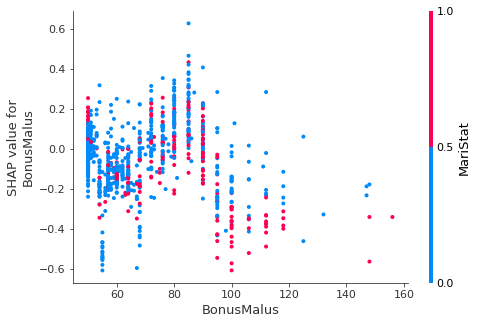

In [71]:
shap.dependence_plot("BonusMalus", shap_values, x_test_ac)

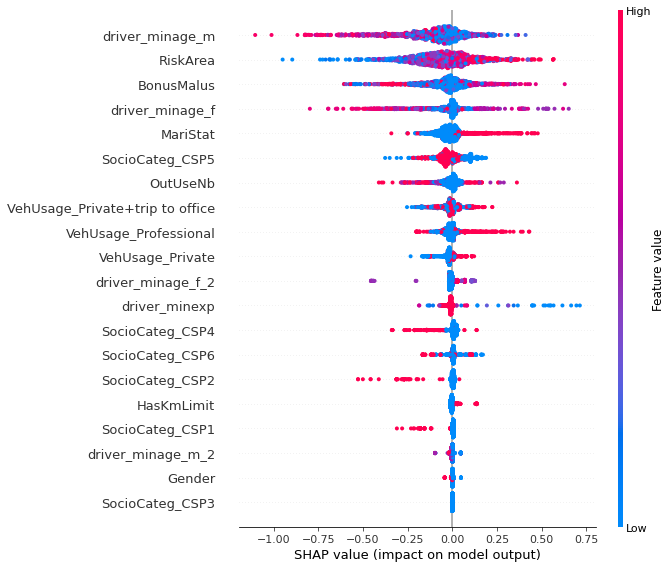

In [72]:
shap.summary_plot(shap_values, x_test_ac)

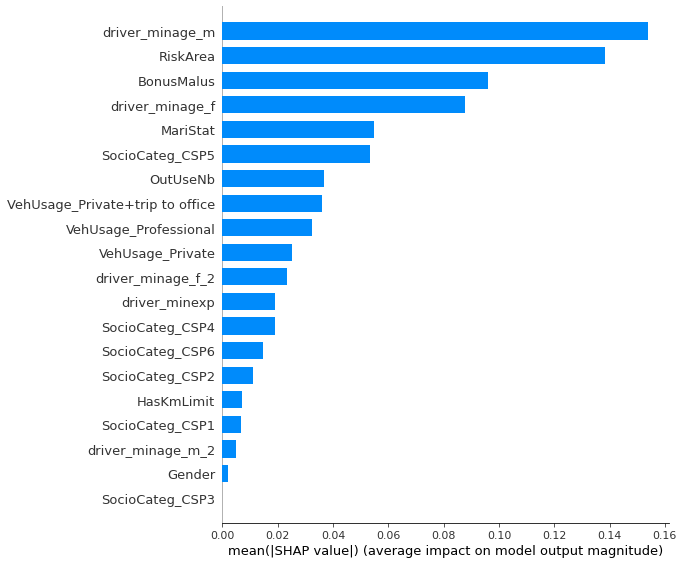

In [73]:
shap.summary_plot(shap_values, x_test_ac, plot_type="bar")

### Использование моделей градиентного бустинга

In [74]:
predictions = pd.DataFrame()
predictions['CountPredicted'] = xgb_freq.predict(xgb.DMatrix(df_freq[col_features]))
predictions['AvgClaimPredicted'] = xgb_avgclaim.predict(xgb.DMatrix(df_freq[col_features]))

In [75]:
predictions['CountPredicted'].min()

0.42975217

In [76]:
predictions['BurningCost'] = predictions.CountPredicted * predictions.AvgClaimPredicted
predictions.head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.459550,1132.795288,520.575684
1,0.459550,1132.795288,520.575684
2,0.453644,797.319397,361.699402
3,0.447734,924.433105,413.899994
4,0.442878,1825.025757,808.263245


Об особенностях сохранения моделей:

In [77]:
xgb_avgclaim.save_model('avg_claim.model')

In [78]:
xgb_avgclaim.feature_names

['driver_minexp',
 'Gender',
 'MariStat',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'driver_minage_m',
 'driver_minage_f',
 'driver_minage_m_2',
 'driver_minage_f_2',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6']

In [79]:
xgb_avgclaim.feature_types

['int',
 'int',
 'int',
 'int',
 'int',
 'float',
 'float',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int']

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin
pd.set_option('max_columns', 200)
PATH=''

In [6]:
df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)

In [7]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [8]:
#delete negative ClaimAmount
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [9]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea'],
      dtype='object')

In [10]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [11]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [14]:
import seaborn as sns

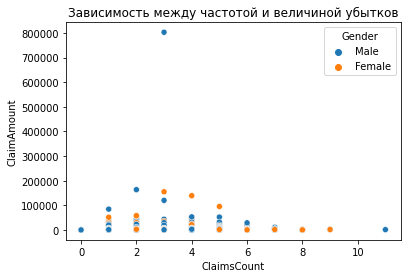

In [15]:
sns.scatterplot( x = df['ClaimsCount'],y = df['ClaimAmount'], hue = df.Gender)
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

In [16]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


In [18]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [19]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [20]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [21]:
pd.get_dummies(df.VehUsage, prefix='VU')

,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0
...,...,...,...,...
115150,0,1,0,0
115151,0,1,0,0
115152,0,1,0,0
115153,1,0,0,0


In [22]:
df = pd.concat([df, pd.get_dummies(df.VehUsage, prefix='VU')], axis=1)
df

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run
0,0.083,332,2004-01-01,2004-02-01,0,0,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0
1,0.916,333,2004-02-01,NaN,0,0,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0
2,0.550,173,2004-05-15,2004-12-03,0,0,CSP50,Private+trip to office,32,0,68,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0
3,0.089,364,2004-11-29,NaN,1,0,CSP55,Private+trip to office,52,0,50,0.000000,0,0.0,8.0,0.0,NaN,0,1,0,0
4,0.233,426,2004-02-07,2004-05-01,0,0,CSP60,Private,57,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,2004-07-29,NaN,0,0,CSP50,Private+trip to office,39,0,50,0.000000,0,4.0,8.0,0.0,NaN,0,1,0,0
115151,1.000,408,2004-01-01,NaN,1,0,CSP55,Private+trip to office,54,0,50,2764.169184,1,0.0,7.0,2.0,1382.084592,0,1,0,0
115152,0.805,211,2004-03-11,NaN,0,0,CSP55,Private+trip to office,35,0,54,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0
115153,0.538,356,2004-01-01,2004-07-15,0,0,CSP50,Private,52,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0


In [23]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [24]:
SocCatSize = pd.DataFrame(df.groupby('SocioCateg').size().sort_values(), columns=['Count'])
SocCatSize

,Count
SocioCateg,
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [25]:
df = pd.concat([df, pd.get_dummies(df.SocioCateg)], axis=1)
df

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7
0,0.083,332,2004-01-01,2004-02-01,0,0,CSP5,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0
1,0.916,333,2004-02-01,NaN,0,0,CSP5,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0
2,0.550,173,2004-05-15,2004-12-03,0,0,CSP5,Private+trip to office,32,0,68,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
3,0.089,364,2004-11-29,NaN,1,0,CSP5,Private+trip to office,52,0,50,0.000000,0,0.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
4,0.233,426,2004-02-07,2004-05-01,0,0,CSP6,Private,57,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,2004-07-29,NaN,0,0,CSP5,Private+trip to office,39,0,50,0.000000,0,4.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
115151,1.000,408,2004-01-01,NaN,1,0,CSP5,Private+trip to office,54,0,50,2764.169184,1,0.0,7.0,2.0,1382.084592,0,1,0,0,0,0,0,0,1,0,0
115152,0.805,211,2004-03-11,NaN,0,0,CSP5,Private+trip to office,35,0,54,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
115153,0.538,356,2004-01-01,2004-07-15,0,0,CSP5,Private,52,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,1,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Exposure                   115155 non-null  float64
 1   LicAge                     115155 non-null  int64  
 2   RecordBeg                  115155 non-null  object 
 3   RecordEnd                  59455 non-null   object 
 4   Gender                     115155 non-null  int64  
 5   MariStat                   115155 non-null  int64  
 6   SocioCateg                 115155 non-null  object 
 7   VehUsage                   115155 non-null  object 
 8   DrivAge                    115155 non-null  int64  
 9   HasKmLimit                 115155 non-null  int64  
 10  BonusMalus                 115155 non-null  int64  
 11  ClaimAmount                115155 non-null  float64
 12  ClaimInd                   115155 non-null  int64  
 13  OutUseNb                   11

In [27]:
df.select_dtypes(exclude='object')

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7
0,0.083,332,0,0,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0
1,0.916,333,0,0,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0
2,0.550,173,0,0,32,0,68,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
3,0.089,364,1,0,52,0,50,0.000000,0,0.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
4,0.233,426,0,0,57,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,0,0,39,0,50,0.000000,0,4.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
115151,1.000,408,1,0,54,0,50,2764.169184,1,0.0,7.0,2.0,1382.084592,0,1,0,0,0,0,0,0,1,0,0
115152,0.805,211,0,0,35,0,54,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0
115153,0.538,356,0,0,52,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,1,0,0


In [28]:
df = df.select_dtypes(exclude='object')

In [29]:
pd.set_option('max_columns', 200)

In [30]:
df['DrivAgeSq'] = df.DrivAge * df.DrivAge
df

<ipython-input-30-97e651fbc268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DrivAgeSq'] = df.DrivAge * df.DrivAge


,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.000000,0,0.0,9.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.000000,0,0.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,0,1,0,3249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,0,0,39,0,50,0.000000,0,4.0,8.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0,1521
115151,1.000,408,1,0,54,0,50,2764.169184,1,0.0,7.0,2.0,1382.084592,0,1,0,0,0,0,0,0,1,0,0,2916
115152,0.805,211,0,0,35,0,54,0.000000,0,0.0,7.0,0.0,NaN,0,1,0,0,0,0,0,0,1,0,0,1225
115153,0.538,356,0,0,52,0,50,0.000000,0,0.0,7.0,0.0,NaN,1,0,0,0,0,0,0,0,1,0,0,2704


In [31]:
df.reindex

<bound method DataFrame.reindex of         Exposure  LicAge  Gender  MariStat  DrivAge  HasKmLimit  BonusMalus  \
0          0.083     332       0         0       46           0          50   
1          0.916     333       0         0       46           0          50   
2          0.550     173       0         0       32           0          68   
3          0.089     364       1         0       52           0          50   
4          0.233     426       0         0       57           0          50   
...          ...     ...     ...       ...      ...         ...         ...   
115150     0.423     238       0         0       39           0          50   
115151     1.000     408       1         0       54           0          50   
115152     0.805     211       0         0       35           0          54   
115153     0.538     356       0         0       52           0          50   
115154     0.461     362       0         0       52           0          50   

        ClaimAmo

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [32]:
NUM_CLASSES = 4
df.loc[df.ClaimsCount > NUM_CLASSES, 'ClaimsCount'] = NUM_CLASSES

c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [33]:
df[df['ClaimsCount'] > NUM_CLASSES]

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,VU_Private,VU_Private+trip to office,VU_Professional,VU_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7,DrivAgeSq


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [34]:
pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Policies'])

,Policies
ClaimsCount,
0.0,104286
1.0,3339
2.0,3529
3.0,2310
4.0,1691


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [35]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size().sort_values(), columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / FreqCount.Count.sum()
FreqCount

,Count,Freq
ClaimsCount,,
4.0,1691,0.014685
3.0,2310,0.020060
1.0,3339,0.028996
2.0,3529,0.030646
0.0,104286,0.905614


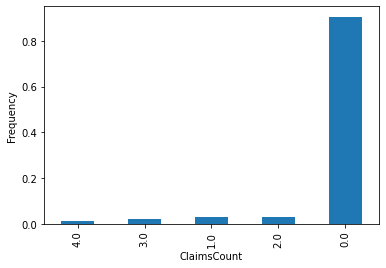

In [36]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [37]:
df['weight'] = FreqCount['Freq'][0]
for i in FreqCount.index:
  df['weight'].loc[df.ClaimsCount == i] = 1 - FreqCount['Freq'][i]

<ipython-input-37-84007e8b1b61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = FreqCount['Freq'][0]
c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-37-84007e8b1b61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [55]:
col_name = df.drop(['ClaimsCount','ClaimAmount', 'ClaimInd', 'AvgClaim'],axis=1).columns
col_name

Index(['Exposure', 'LicAge', 'Gender', 'MariStat', 'DrivAge', 'HasKmLimit',
       'BonusMalus', 'OutUseNb', 'RiskArea', 'VU_Private',
       'VU_Private+trip to office', 'VU_Professional', 'VU_Professional run',
       'CSP1', 'CSP2', 'CSP3', 'CSP4', 'CSP5', 'CSP6', 'CSP7', 'DrivAgeSq',
       'weight'],
      dtype='object')

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [56]:
from sklearn.model_selection import train_test_split

In [67]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'AvgClaim'], axis=1), df.ClaimsCount, test_size=0.30, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_train, y_train, test_size=0.15, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [68]:
xgb_train = xgb.DMatrix(x_train, y_train)
xgb_valid = xgb.DMatrix(x_valid, y_valid)
xgb_test = xgb.DMatrix(x_test, y_test)

In [69]:
print(np.unique(xgb_train.get_label()))
print(np.unique(xgb_test.get_label()))
print(np.unique(xgb_valid.get_label()))

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [70]:
# Зададим функцию оценки модели для мультиклассовой модели

# кастомная метрика (тут она собственно простая : равен не равен)
# метрика может решать любые удобные нам вопросы (например не учитывать какой-то вариант как ошибку )
# Метрика должна учесть специфику задачи
# принимает 2 набора на вход : целевое состояние и состояние выхода модели для каждого примера 
# это не функция потерь (для нее нужно найти градиент и Гессиан) - это просто метрика результата
def xgb_eval(yhat, dtrain):   
    # ответ модели на входный примеры (тип примеров : тесты или трейны )
    y = dtrain.get_label()
    #  как-то вычисляем потери (можно так, можно паостроить вероятностные потери - logloss)
    errors = np.zeros(y.shape[0])
    errors[y != yhat] = 1.0
    # 
    return 'dev_myerror', np.sum(errors) / y.shape[0]

In [71]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE
# задача этой функции как угодно , но определить метрику качества модели (сравнивать модели будем по ней)
# Обычно - нежно провести обучение и измерить внешний критерий (какую-то метрику. какую метрику брать, выбираем по тому, что нам нужно от модели)
def objective(params):
    # параметры XGBoosta (https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)
    #   'objective' -  задает тип задачи (тип выходного процесса) - может быть регрессией 'reg' , счетным 'count' - счетный выход (у нас счетный или мультикласс), 'multi' - многоклассовая модель например по softmax , бинарным 'binary' и еще несколько менее простых вариантов
    #  'objective':'multi:softmax' - тип задачи на выходе  - это зависит только от выхода нашей задачи - для нашей классификации можно предположить 'multi:softmax' или его вероятностный аналог 
    # 'subsample' - объем подвыборки обучающих примеров относительно поданной выборки (умолчание 1). если 0,5, то  XGBoost будет случайным образом выбирать половину данных для построения деревьев ( цель - борьба с переобучегнием)
    #  'min_child_weight' - соответствует минимальному количеству экземпляров в узле для принятия решения , что это лист, которое должно быть в каждом узле. 
    #  'colsample_bytree' - коэффициент использования признаков при построении каждого дерева. Если 0.5, то берем половину признаков из списка
    #  'eta' - одно из имен скорости обучения 
    #   'alpha', 'lambda' - параметры регуляризации (L1,L2)
    parameters = {
        'objective': 'multi:softmax', # внутренний критерий берем по умолчанию 
        #(если хотим свой, то пишем функцию потерь, которая должна найти градиент и Гесиан (пример https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_softmax.py))
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],        
        'num_class': 5,  # число классов
    }
    # с этими параметрами запускаем кросвалидационную тренировку
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0, maximize=False, feval=xgb_eval, early_stopping_rounds=10)
    # делаем оценку модели на тестовом наборе для собственной метрики
    score = cv_result['test-dev_myerror-mean'][-1:].values[0]
    return score

In [72]:
# настраиваем деревья - можно использовать все параметры для управления ростом деревьев в xgboost https://xgboost.readthedocs.io/en/latest/parameter.html
# тут наиболее важные для модели
# Определим границы, в которых будем искать гиперпараметры 
# Это пространство, где ищем лучшее решение по параметрам xgboost классификатора
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
        }

In [73]:
# Оптимизация (количество итераций снижено для ускорения работы)
# objective - просто оценка моделей - внешний критерий
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-70-834fb777dbfa>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  errors[y != yhat] = 1.0



100%|███████████████████████████████████████████████████████████████| 50/50 [04:23<00:00,  5.28s/trial, best loss: 1.0]


Далее обучим нашу модель с оптимальными параметрами

In [74]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 5  # число классов указываем -  5

best_params

{'alpha': 0.6945196183053591,
 'colsample_bytree': 0.7479513534125616,
 'eta': 0.7270617579656005,
 'lambda': 0.650564767158647,
 'max_depth': 5,
 'min_child_weight': 33.887029914454445,
 'num_boost_round': 136.0,
 'subsample': 0.7832535069453109,
 'objective': 'multi:softmax',
 'num_class': 5}

In [75]:
progress = dict()
xgb_freq = xgb.train(  params=best_params, dtrain=xgb_train, feval=xgb_eval, maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

[18:29:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<ipython-input-70-834fb777dbfa>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  errors[y != yhat] = 1.0


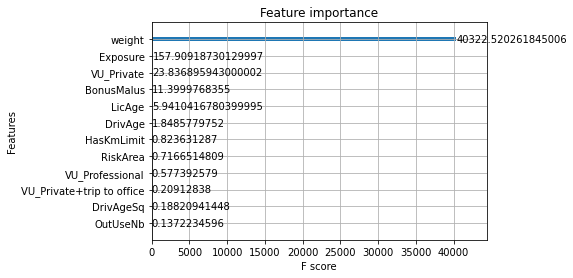

In [76]:
importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[0]); plt.show()

Надо убрать веса)

In [99]:
x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(df.loc[:,col_name], df.ClaimsCount, test_size=0.3, random_state=10)
x_valid_cl, x_test_cl, y_valid_cl, y_test_cl = train_test_split(x_test_cl, y_test_cl, test_size=0.5, random_state=10)

In [100]:
xgb_train = xgb.DMatrix(x_train_cl.drop('weight', axis = 1), (y_train_cl), weight = x_train_cl.weight)
xgb_valid = xgb.DMatrix(x_valid_cl.drop('weight', axis = 1), (y_valid_cl))
xgb_test = xgb.DMatrix(x_test_cl.drop('weight', axis = 1), (y_test_cl))

In [101]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK
### Второй вариант оценки модели
def objective(params, n_folds=3):

# Converting pandas dataframe into xgboost format
    d_train = xgb_train

    num_boost_round = int(params['num_boost_round'])
#    metrics = params['metrics']   - родной вариант метрики для многоклассовой классификации по xgboost  

# metrics = 'merror' - используем  умолчания для мультиклассов (он описан и реализован в xgboost)
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round = num_boost_round, 
                        early_stopping_rounds = 10, metrics = 'merror', seed = 0)
  
#  измеряем нашу метрику и вернем ее на уровень сохранения результатов для этой модели 
    loss = min(cv_results['test-merror-mean'])
    return loss

In [102]:
### настраиваем деревья - можно использовать все параметры для управления ростом деревьев в xgboost https://xgboost.readthedocs.io/en/latest/parameter.html
# тут наиболее важные для модели
xgb_space = {
#    max_depth : maximum depth allowed for every tree
# hp.choice.choice will select 1 value from the given list
    'max_depth':hp.hp.choice('max_depth', np.arange(3, 15,1, dtype=int)),
#    subsample : maximum allowed rows for every tree
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
#    colsample_bytree : maximum allowed features for every tree
# hp.hp.quniform returns a float between a given range
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
#    min_child-weight : minimum number of instances required in each node
    'min_child_weight':hp.hp.quniform('min_child_weight', 0, 1000,100),
#    reg_alpha : L1 regularisation term on weights
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1.0),
#    reg_lambda : L2 regularisation term on weights
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1.0),
#    'alpha': hp.hp.uniform('alpha', 0, 1),
#    'lambda': hp.hp.uniform('lambda', 0, 1),
    'eta': hp.hp.uniform('eta', 0.01, 1),
    'num_boost_round': hp.hp.quniform('num_boost_round', 50, 500, 1),
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': len(FreqCount)  # число классов должно соответсвовать выходному признаку 
#    (если нет какой-то из меток, то ошибка, если пропущена метка, то ошибка, если лишняя метка, то ошибка) 
    }

In [103]:

### step 3 : storing the results of every iteration    
bayes_trials = Trials()
MAX_EVALS = 20

# Optimize
best = fmin(fn = objective, space = xgb_space, algo = hp.tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

### best will the return the the best hyperparameter set

[19:14:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This

[19:14:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This

[19:15:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { num_boost_round } might not be used.

  This

100%|██████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/trial, best loss: 0.519387]


In [104]:
best_params = space_eval(xgb_space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] =  5
best_params

{'colsample_bytree': 0.6000000000000001,
 'eta': 0.8850530298975089,
 'max_depth': 13,
 'min_child_weight': 500.0,
 'num_boost_round': 284.0,
 'num_class': 5,
 'objective': 'multi:softmax',
 'reg_alpha': 0.22139460970492442,
 'reg_lambda': 0.820407994988511,
 'subsample': 0.9500000000000001}

In [105]:
progress = dict()

xgb_count = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), dtrain=xgb_train,
                        params=best_params, evals=[(xgb_train, 'train'),(xgb_valid, 'valid')],
                        early_stopping_rounds=10, evals_result = progress )

[0]	train-merror:0.52041	valid-merror:0.09223
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.52041	valid-merror:0.09223
[2]	train-merror:0.52045	valid-merror:0.09234
[3]	train-merror:0.52045	valid-merror:0.09333
[4]	train-merror:0.51957	valid-merror:0.09767
[5]	train-merror:0.51919	valid-merror:0.09981
[6]	train-merror:0.51878	valid-merror:0.10502
[7]	train-merror:0.51859	valid-merror:0.10664
[8]	train-merror:0.51746	valid-merror:0.11046
[9]	train-merror:0.51753	valid-merror:0.11289
[10]	train-merror:0.51764	valid-merror:0.11191
Stopping. Best iteration:
[0]	train-merror:0.52041	valid-merror:0.09223



In [106]:
xgb_count.save_model('GB_lesson_3_home_task.model')

In [107]:
preds_xgb_train = xgb_count.predict(xgb_train)
best_preds_xgb_train = np.asarray([np.argmax(line) for line in preds_xgb_train])


preds_xgb_valid = xgb_count.predict(xgb_valid)
best_preds_xgb_valid = np.asarray([np.argmax(line) for line in preds_xgb_valid])

preds_xgb_test = xgb_count.predict(xgb_test)
best_preds_xgb_test = np.asarray([np.argmax(line) for line in preds_xgb_test])

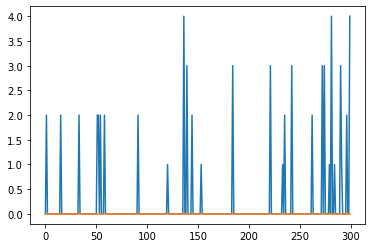

In [108]:
plt.plot(xgb_test.get_label()[:300])
plt.plot(best_preds_xgb_test[:300])
plt.show()

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [109]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [114]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train_cl},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid_cl},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test_cl}]
for dfset in dfsets:
    class_preds = xgb_count.predict(dfset['dmat'])## Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.8889440254069075
F1 Score on valid: 0.8880912406646211
F1 Score on test: 0.8899502141947436


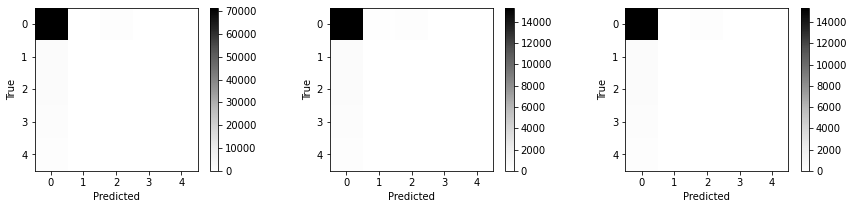

In [116]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_count.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Все предсказания без убытка. Модель не рабочая. Либо из-за несбалансированности выборки, либо плохо проведен отбор параметров/создание новых фич.